### Imports and function definitions

In [1]:
import tensorflow as tf
print('tensorflow version: ', tf.__version__)

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow_datasets as tfds
print('tfds version: ', tfds.__version__)
import pandas as pd
from tensorflow.keras.callbacks import TensorBoard
import datetime as datetime

from IPython import display

tensorflow version:  2.4.1
tfds version:  4.2.0


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPUs: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2
GPUs:  2


### Ways to iterate over the dataset

### Load and Prepare the Dataset / Preprocessing Functions

In [3]:
#https://www.tensorflow.org/datasets/keras_example

(ds_train_raw, ds_test_raw), ds_info = tfds.load(
    'celeb_a',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def preprocess(data):
    """Normalizes images: `uint8` -> `float32`."""
    image = data['image']
    label = data['attributes']
    image = tf.image.resize(image[20:-20], [64, 64], antialias=True)
    image = tf.cast(image, tf.float32) / 255. # normalise images to between 0 and 1
    return image, label

ds_train = ds_train_raw.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [4]:
ds_train

<PrefetchDataset shapes: ((None, 64, 64, 3), {5_o_Clock_Shadow: (None,), Arched_Eyebrows: (None,), Attractive: (None,), Bags_Under_Eyes: (None,), Bald: (None,), Bangs: (None,), Big_Lips: (None,), Big_Nose: (None,), Black_Hair: (None,), Blond_Hair: (None,), Blurry: (None,), Brown_Hair: (None,), Bushy_Eyebrows: (None,), Chubby: (None,), Double_Chin: (None,), Eyeglasses: (None,), Goatee: (None,), Gray_Hair: (None,), Heavy_Makeup: (None,), High_Cheekbones: (None,), Male: (None,), Mouth_Slightly_Open: (None,), Mustache: (None,), Narrow_Eyes: (None,), No_Beard: (None,), Oval_Face: (None,), Pale_Skin: (None,), Pointy_Nose: (None,), Receding_Hairline: (None,), Rosy_Cheeks: (None,), Sideburns: (None,), Smiling: (None,), Straight_Hair: (None,), Wavy_Hair: (None,), Wearing_Earrings: (None,), Wearing_Hat: (None,), Wearing_Lipstick: (None,), Wearing_Necklace: (None,), Wearing_Necktie: (None,), Young: (None,)}), types: (tf.float32, {5_o_Clock_Shadow: tf.bool, Arched_Eyebrows: tf.bool, Attractive: tf

In [5]:
for images, attributes in ds_train:
    break
print(images.shape)
print(attributes.keys())

(128, 64, 64, 3)
dict_keys(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young'])


In [6]:
images[0].shape

TensorShape([64, 64, 3])

In [7]:
images.numpy().max()

1.0000002

## Create the models

### Generator

The generator uses tf.keras.layers.Conv2DTranspose (upsampling) layers to produce an image from a seed (random noise). Start with a Dense layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the tf.keras.layers.LeakyReLU activation for each layer, except the output layer which uses tanh.

In [8]:
# Add attribute vectors
#attributes.items()

In [9]:
#attributes.values()

In [10]:
# The generator
def make_generator_model():
    
    model = tf.keras.Sequential(name='Generator')
    # add noise layer
    model.add(layers.GaussianNoise(stddev=0.1, input_shape=(40,)))
    # Densly connection NN layer of 8*8*256 (16,384) neurons. This is taking in the input initialisation and multiplying with the weights
    model.add(layers.Dense(8*8*256, use_bias=False)) 
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(16, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.LeakyReLU())
    
    # Output layer
    model.add(layers.Conv2D(3, (3,3), activation='sigmoid', padding = 'same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 3)

    return model

### Discriminator

The discriminator is a CNN-based image classifier.

In [11]:
#noise = tf.random.normal([64, 64, 3])
#noise.shape

In [12]:
def make_discriminator_model():
    
    # label input
    attribute_vector = layers.Input(shape=(40))
    input_image = layers.Input(shape=(64,64,3))
    #noise = tf.random.normal([64, 64, 3])
    
    conv_model = tf.keras.Sequential(name='Discriminator_conv_model')
    
    # gan hacks - add noise
    conv_model.add(layers.GaussianNoise(stddev=0.1))
    
    # downsample
    conv_model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same'))
    conv_model.add(layers.BatchNormalization())
    conv_model.add(layers.LeakyReLU())
    
    #downsample
    conv_model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    conv_model.add(layers.BatchNormalization())
    conv_model.add(layers.LeakyReLU())
    
    #downsample
    conv_model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    conv_model.add(layers.LeakyReLU())
    conv_model.add(layers.Dropout(0.3))
    
    # classifier
    conv_model.add(layers.Flatten()) # flatten to 1D array
    
    # Concatentate the new one here
    # The feed the concatenated model into the dense layer
    
    #img_feature_vec = conv_model(input_image+noise*1)
    img_feature_vec = conv_model(input_image)
    
    # concatenate layers - the image vector + the attribute labels
    merge = layers.Concatenate()([img_feature_vec, attribute_vector])
    
#     # multi-layer perceptrons
#     mlp = tf.keras.Sequential(name='Discriminator_mlp')
#     mlp.add(layers.Dense(128))
#     mlp.add(layers.LeakyReLU())
#     mlp.add(layers.Dropout(0.3))
#     mlp.add(layers.Dense(1))

    # linear layer that takes in merge and makes a prediction based on that
    output = layers.Dense(1)(merge)
    
    # Need to create new model here with correct shapes which need to be defined as inputs
    model = tf.keras.Model(inputs=[input_image, attribute_vector], outputs=output, name='Discriminator')

    return model

In [13]:
# Create Models
# Classify the generated images as real or fake using the discriminator.
# Model is trained to output positive values for real images and negative values for fake images
generator = make_generator_model()
discriminator = make_discriminator_model()

#decision = discriminator((generated_image, attributes_noise))
#print(decision.shape)
#print(decision[:10])

## Define the loss and optimisers

In [14]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

Quantifies how well the discriminator is able to distinguish real images from fakes.  

It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s

In [15]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss

Quantifies how well it was able to trick the discriminator.  

If the generator is performng well, the discriminator will classify the fake images as real (or 1). This function compares the discriminators decisions on the generated images to an array of 1s

In [16]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Optimisers

Two different optimisers required since the two networks are trained separately

In [17]:
noise_dim = 40
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
attribute_embeddings = tf.Variable(initial_value=tf.random.normal([40, noise_dim]), trainable=True) # Do this once only, but add to optimizers

### Save checkpoints

In [18]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
                                 #attribute_embeddings=attribute_embeddings)

## Training Loop

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [19]:
def initiate_seed_weights(attributes):
    # Convert to tensor
    #print(attributes.values().shape)
    #print('p1: ',attribute_embeddings.shape, type(attribute_embeddings))
    batch_attributes_as_bool_tensor = tf.transpose(tf.stack(list(attributes.values())))
    #print('p2: ',batch_attributes_as_bool_tensor.shape, type(batch_attributes_as_bool_tensor))
    # Convert from boolean to float
    batch_attributes_as_float_tensor = tf.where(batch_attributes_as_bool_tensor, 1.,-1.)
    #print('p3: ',batch_attributes_as_float_tensor.shape, type(batch_attributes_as_float_tensor))
    # Create projection of attributes into embedding space
    #attribute_input = tf.matmul(batch_attributes_as_float_tensor, attribute_embeddings) 
    attribute_input = batch_attributes_as_float_tensor
    return attribute_input

#attributes_random = np.random.choice(a=[False, True], size=(128,40)) # this doesn't seem to be used anywhere
#attributes_noise = initiate_seed_weights(attributes, attribute_embeddings)
#attributes_noise = initiate_seed_weights(attributes)

#print(attributes_noise.shape)
#print(type(attributes_noise))

In [20]:
@tf.function
def train_step(images, attributes):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        attribute_input = initiate_seed_weights(attributes)

        # Make prediction
        generated_images = generator(attribute_input, training=True)
        real_output = discriminator((images, attribute_input), training=True)
        fake_output = discriminator((generated_images, attribute_input), training=True)

        # Calculate loss
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        # Keep an eye on what discriminator is deciding (visualised in tensorboard)
        mean_real_output = tf.math.reduce_mean(tf.nn.sigmoid(real_output))
        mean_fake_output = tf.math.reduce_mean(tf.nn.sigmoid(fake_output))

    # Calculate gradients - the derivative of the loss with respect to the model weights
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # Tweak model weights based on optimiser calculations
    # zip function is used to align the array of 128 (or diff batch size) gradients with the 128 trainable variables that the gradients will update
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return attribute_input, gen_loss, disc_loss, mean_real_output, mean_fake_output
    
def train(dataset, epochs, num_examples_to_generate):
    
    # tensorboard callback
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    log_dir='tensorboard_log/' + current_time
    summary_writer = tf.summary.create_file_writer(log_dir)
        
    for epoch in range(epochs):
        start = time.time()

        for image_batch, attribute_batch in dataset:
            attribute_input, gen_loss, disc_loss, mean_real_output, mean_fake_output = train_step(image_batch, attribute_batch)

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, attribute_input[:num_examples_to_generate])
        
        # save data for tensorboard
        with summary_writer.as_default():
            tf.summary.scalar('gen_loss', gen_loss, step=epoch)
            tf.summary.scalar('disc_loss', disc_loss, step=epoch)
            tf.summary.scalar('mean_real_output', mean_real_output, step=epoch)
            tf.summary.scalar('mean_fake_output', mean_fake_output, step=epoch)

        # Save the model every 50 epochs
        if (epoch + 1) % 50 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    
# Generate and save images
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False. This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(10, 10))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i])
        plt.axis('off')

    image_folder = 'generated_images/'
    image_filepath = image_folder + 'image_at_epoch_{:04d}.png'
    plt.savefig(image_filepath.format(epoch))
    plt.show()


## Train the model

Generator and discriminator are trained simultaneously.  

It is important that the generator and discriminator do not overpower each other (i.e. they train at a similar rate)

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

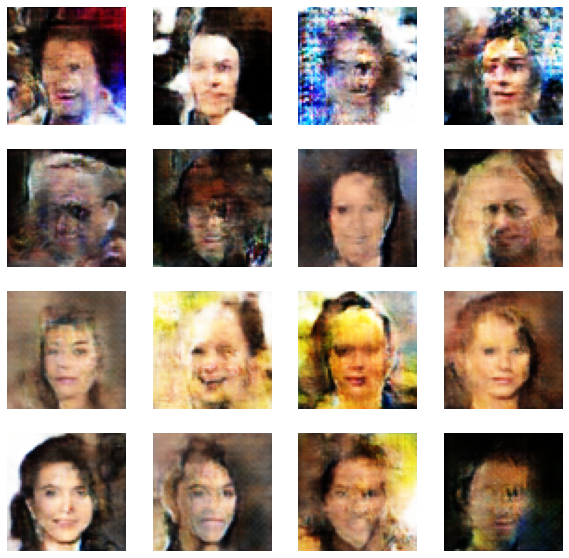

Time for epoch 179 is 97.54450416564941 sec


In [ ]:
EPOCHS = 200
noise_dim = 100
num_examples_to_generate = 16

train(ds_train, EPOCHS, num_examples_to_generate)

In [ ]:
assert False

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

### Generate images according to attributes

In [ ]:
print(len(attributes.keys()))
attributes.keys()

In [ ]:
attribute_base_dict = {}

for idx, attribute in enumerate(attributes.keys()):
    attribute_base_dict[attribute] = False

#attribute_base_dict

In [ ]:
#attribute_to_test = ['Eyeglasses', 'Male', 'Attractive']

def attributes_bool_ordered(attribute_base_dict, attribute_to_find):
    """
    order boolean values in same order as received by model
    output: boolean values
    """
    attribute_to_find = list(attribute_to_find)
    
    attribute_values = []
    for attribute in sorted(attribute_base_dict.keys()):
        attribute_values.append(True if attribute in attribute_to_find else False)
        
    return attribute_values
    
#attribute_values = attributes_bool_ordered(attribute_base_dict, attribute_to_test)
print(len(attribute_values))
print(type(attribute_values)) # list of true and false
#attribute_values

In [ ]:
def attributes_multiple_list(attribute_to_find):
    if any(isinstance(item, list) for item in attribute_to_find):
        attribute_values = []
        for attribute_list in attribute_to_find:
            attribute_values.append(attributes_bool_ordered(attribute_base_dict, attribute_list))
        
    else:
        attribute_values = attributes_bool_ordered(attribute_base_dict, attribute_to_find)
    return attribute_values

In [ ]:
attribute_to_test = [['Eyeglasses', 'Male', 'Attractive'], ['Eyeglasses', 'Male', 'Attractive', 'Blond_Hair']]
#attribute_to_test = ['Eyeglasses', 'Male', 'Attractive']
attribute_to_test = attributes_multiple_list(attribute_to_test)
#attribute_to_test

In [ ]:
tf.stack(list(attribute_to_test))

In [ ]:
tf.stack(list(attribute_to_test))

In [ ]:
def convert_attrbutes_to_vec(attributes, attribute_embeddings):
    
    # Order attributes
    #attributes = attributes_bool_ordered(attribute_base_dict, attributes)
    attributes = attributes_multiple_list(attributes)
    
    # Convert to tensor
    print('p1: ',attribute_embeddings.shape, type(attribute_embeddings))
    batch_attributes_as_bool_tensor = tf.stack(list(attributes))
    print('p2: ',batch_attributes_as_bool_tensor.shape, type(batch_attributes_as_bool_tensor))
    batch_attributes_as_bool_tensor = tf.reshape(batch_attributes_as_bool_tensor, [5,40])
    print('p2: ',batch_attributes_as_bool_tensor.shape, type(batch_attributes_as_bool_tensor))
    
    # Convert from boolean to float
    batch_attributes_as_float_tensor = tf.where(batch_attributes_as_bool_tensor, 1.,-1.)
    print('p3', batch_attributes_as_float_tensor.shape, type(batch_attributes_as_float_tensor))
    
    # Create projection of attributes into embedding space
    attribute_input = tf.matmul(batch_attributes_as_float_tensor, attribute_embeddings) 
    return attribute_input

In [ ]:
attribute_to_test = ['Eyeglasses', 'Male', 'Attractive', 'Blond_Hair']
#attribute_to_test = ['Eyeglasses', 'Male', 'Attractive']

attributes_test = convert_attrbutes_to_vec(attribute_to_test, attribute_embeddings)
print(attributes_test.shape, type(attributes_test))

In [ ]:
attribute_to_test = ['Eyeglasses', 'Male', 'Attractive', 'Blond_Hair']
#attribute_to_test = ['Eyeglasses', 'Male', 'Attractive']
attribute_to_test = [['Eyeglasses', 'Male', 'Attractive'], ['Eyeglasses', 'Male', 'Attractive', 'Blond_Hair'], ['Eyeglasses', 'Male', 'Blond_Hair'], 
                     ['Attractive', 'Blond_Hair'],['Attractive', 'Blond_Hair', 'Wearing_Lipstick']]


attributes_test = convert_attrbutes_to_vec(attribute_to_test, attribute_embeddings)
print(attributes_test.shape, type(attributes_test))

In [ ]:
# Try generating an image based on specific attributes
attributes_noise = initiate_seed_weights(attributes)

generated_image = generator(attributes_test, training=False)
print(generated_image.dtype)
print(generated_image.shape)

fig = plt.figure(figsize=(10, 10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(generated_image[i])
    plt.axis('off')

#plt.imshow(generated_image[1])

None

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('./generated_images/image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(50)

In [ ]:
attributes_random = np.random.choice(a=[False, True], size=(128,40))
print(attributes_random[1].shape)
attributes_random[1]

In [ ]:
generator.summary()

In [ ]:
discriminator.summary()